In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt

from gymnasium.wrappers import FrameStack

In [2]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer_actor = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.observation_buffer_critic = np.zeros(
            (size, 4, 4), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation_actor, observation_critic, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer_actor[self.pointer] = observation_actor
        self.observation_buffer_critic[self.pointer] = observation_critic
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer_actor,
            self.observation_buffer_critic,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = keras.ops.log_softmax(logits)
    logprobability = keras.ops.sum(
        keras.ops.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


seed_generator = keras.random.SeedGenerator(1337)


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = keras.ops.squeeze(
        keras.random.categorical(logits, 1, seed=seed_generator), axis=1
    )
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = keras.ops.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = keras.ops.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -keras.ops.mean(
            keras.ops.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = keras.ops.mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = keras.ops.sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = keras.ops.mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [3]:
# Hyperparameters of the PPO algorithm
steps_per_epoch = 120
epochs = 12
gamma = 0.99
clip_ratio = 0.2
policy_learning_rate = 3e-4
value_function_learning_rate = 1e-3
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97
target_kl = 0.01
hidden_sizes = (64, 64)

# True if you want to render the environment
render = False

In [4]:
# Initialize the environment and get the dimensionality of the
# observation space and the number of possible actions
env = gym.make("CartPole-v1")
observation_dimensions = env.observation_space.shape[0]
num_actions = env.action_space.n

stacked_frames=4

env = FrameStack(env, stacked_frames)
print(env.observation_space)
#flattening env again
#env = gym.wrappers.FlattenObservation(env)
#print(env.observation_space)

# Initialize the buffer
buffer = Buffer(observation_dimensions, steps_per_epoch)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
logits = mlp(observation_input, list(hidden_sizes) + [num_actions])
actor = keras.Model(inputs=observation_input, outputs=logits)


##CHANGING just! the value/critic neural network
observation_input = keras.Input(shape=(None,4),  dtype="float32")
y = layers.LSTM(64, return_sequences=True, activation="relu")
y = y(observation_input)
y = layers.LSTM(64)(y)
val = layers.Dense(1)(y)

#value = keras.ops.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
value = keras.ops.squeeze(val, axis=1)
#print(f"value is {value}")

critic = keras.Model(inputs=observation_input, outputs=value)


#value = keras.ops.squeeze(mlp(observation_input, list(hidden_sizes) + [1]), axis=1)
#critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

# Initialize the observation, episode return and episode length
observation, _ = env.reset()
episode_return, episode_length = 0, 0


mean_return_info_value_LSTM = []

Box([[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
 [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
 [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
 [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]], [[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]], (4, 4), float32)


In [5]:
# Iterate over the number of epochs
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        
        #print(f"observation is {observation}")
        
        # Get the logits, action, and take one step in the environment
        #observation = np.array(observation)

        #print(f"observation, now an array, is {observation}")

        observation = np.array(observation)
        observation = observation.reshape(4, 4)
        #print(f"observationa after reshape is {observation}")
        #print(f"observation[0] after reshape is {observation[0]}")
        
        observation_actor = observation[0]
        observation_actor = observation_actor.reshape(1,4)
        #print(f"observation for the actor is is {observation_actor}")
        observation = observation.reshape(1, 4, 4)
        #print(f"observation for the critic is {observation}")
        
        logits, action = sample_action(observation_actor)
        #observation_actor = observation[0]
        #logits, action = sample_action(observation)
        observation_new, reward, done, _, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation_actor, observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = np.array(observation_new)

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, 4, 4))
            #last_value = 0 if done else critic(observation)
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, _ = env.reset()
            episode_return, episode_length = 0, 0

    # Get values from the buffer
    (
        observation_buffer_actor,
        observation_buffer_critic,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer_actor, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer_critic, return_buffer)

   
    #mean_return_info[epoch] = ((sum_return/num_episodes), epoch+1)

    mean_return_info_value_LSTM.append([epoch, (sum_return / num_episodes)])

    # Print mean return and length for each epoch
    print(
        f" Epoch: {epoch + 1}. Mean Return: {sum_return / num_episodes}. Mean Length: {sum_length / num_episodes}"
    )

 Epoch: 1. Mean Return: 40.0. Mean Length: 40.0
 Epoch: 2. Mean Return: 24.0. Mean Length: 24.0
 Epoch: 3. Mean Return: 20.0. Mean Length: 20.0
 Epoch: 4. Mean Return: 24.0. Mean Length: 24.0
 Epoch: 5. Mean Return: 60.0. Mean Length: 60.0
 Epoch: 6. Mean Return: 60.0. Mean Length: 60.0
 Epoch: 7. Mean Return: 60.0. Mean Length: 60.0
 Epoch: 8. Mean Return: 30.0. Mean Length: 30.0
 Epoch: 9. Mean Return: 60.0. Mean Length: 60.0
 Epoch: 10. Mean Return: 30.0. Mean Length: 30.0
 Epoch: 11. Mean Return: 40.0. Mean Length: 40.0
 Epoch: 12. Mean Return: 60.0. Mean Length: 60.0


0
1
2
3
4
5
6
7
8
9
10
11


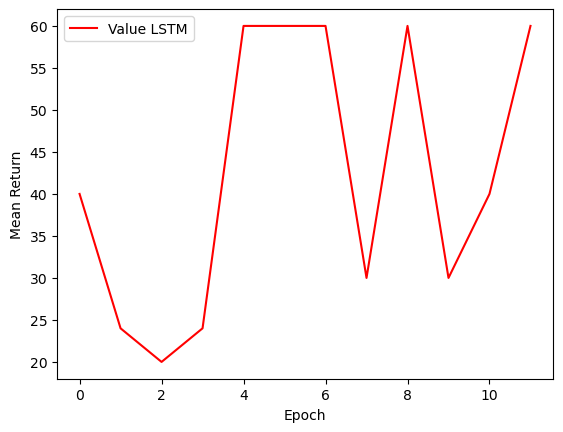

In [6]:
x = []
y = []
for i in range(epochs):
    print(i)
    x.append(mean_return_info[i][0])
    y.append(mean_return_info[i][1])
    i+=1
    
plt.plot(x, y, 'r', label="Value LSTM")
plt.xlabel('Epoch')
plt.ylabel('Mean Return')
plt.legend()